In [1]:
blenderExec = '/home/eecs/shubhtuls/Downloads/blender-2.76/blender' --change this to absolute path on local machine
demoName = 'pascal' --'pascal' or 'shapenet' demo
visMeshesDir = '../cachedir/demo/' --directory where the meshes, rendrings should be saved
paths.mkdir(visMeshesDir)

In [2]:
require 'nn'
require 'cunn'
require 'cudnn'
require 'image'
matio = require 'matio'
cropUtil = dofile('../utils/cropUtils.lua')
demoUtil = dofile('demoUtils.lua')

In [3]:
cachedir = '../cachedir'
if(demoName == 'pascal') then
    netName = 'p3dSNetCombined'
    netIter = 20000
    snapshotDir = paths.concat(cachedir,'snapshots','pascal', netName)
elseif(demoName == 'shapenet') then
    netName = 'chair_depth_nIm5'
    netIter = 10000
    snapshotDir = paths.concat(cachedir,'snapshots','shapenet', netName)
end
predNet = torch.load(paths.concat(snapshotDir, 'iter' .. netIter .. '.t7'))
predNet = predNet:cuda()
predNet:evaluate()

In [4]:
if(demoName == 'pascal') then
    voc_rec_id = '2009_004243_1.mat'
    state = matio.load(paths.concat('data', voc_rec_id))
    local bbox = state.bbox:view(4)
    imgRgb = state.im:transpose(2,3):transpose(1,2):double():mul(1/255)
    imgRgb = cropUtil.cropImg(imgRgb:double(),torch.Tensor({bbox[1],bbox[2],bbox[1]-1+bbox[3],bbox[2]-1+bbox[4]}), 0.15, 0)
else
    imgRgb = image.load(paths.concat('data', 'snet_chair.png'))
    local alphaMask = imgRgb[4]:repeatTensor(3,1,1)
    imgRgb = torch.cmul(imgRgb:narrow(1,1,3),alphaMask) + 1 - alphaMask
end
imgRgbVis = imgRgb:clone()
imgRgb = image.scale(imgRgb,64,64)
imgRgb = imgRgb:reshape(1,3,64,64)


In [5]:
if(demoName == 'pascal') then
    imgRgbInput = cropUtil.resnetPreprocess(imgRgb)
else
    imgRgbInput = imgRgb:clone()
end

predOut = predNet:forward(imgRgbInput:cuda()):clone():float()
predOut = 1-predOut[1][1]


In [6]:
demoUtil = dofile('demoUtils.lua')
blendFile = 'renderer/model.blend' -- needed for rendering
local predMesh = visMeshesDir .. demoName .. '_pred.obj'
local predPng = visMeshesDir .. demoName .. '_pred.png'
local verts, faces = demoUtil.voxelsToMesh(predOut, 0.25)
verts = torch.mm(verts, torch.Tensor({{1,0,0}, {0,0,1}, {0,1,0}}))
demoUtil.writeObj(predMesh, verts, faces)
demoUtil.renderMesh(blenderExec, blendFile, predMesh, predPng)
imPred = image.crop(demoUtil.RGBAtoRGB(image.load(predPng)), 350, 1, 750, 401)

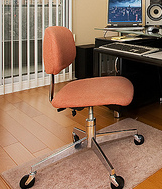

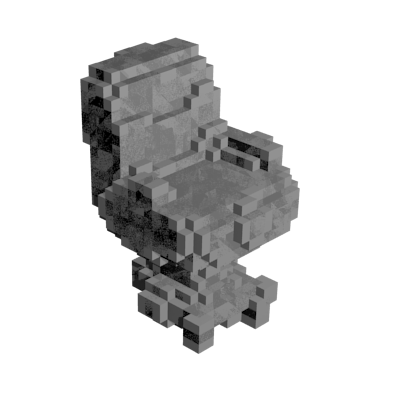

In [7]:
itorch.image(imgRgbVis)
itorch.image(imPred)